# 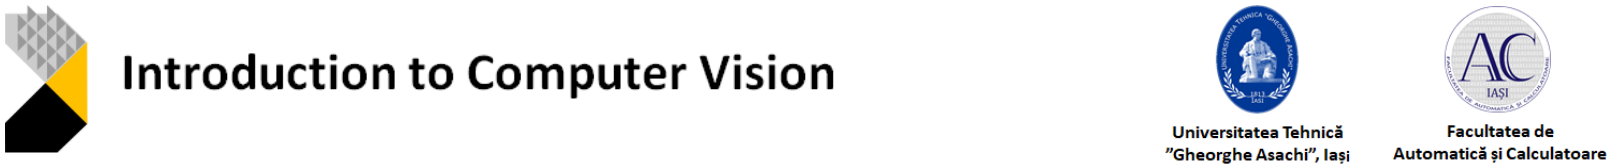

  The Intro to Computer Vision labs will be run in Google Colaboratory, a Jupyter notebook environment that runs entirely in the cloud, you don't need to download anything. To run these labs, you must have a Google account.

Step 1: click on the assignment invite link -> **Accept this assignment**. Refresh page -> individual repo for the specific assignment is created automatically

Step 2: Navigate to http://colab.research.google.com/github -> Click the **Include Private Repos** checkbox -> **select the correct repo** (SistemeDeVedereArtificiala/assignment_name-student_name) -> Click on the jupyter notebook of the current assignment

Step 3: [GitHub sign-in window] In the popup window, sign-in to your Github account and authorize Colab to read the private files.

Step 4: [in colab] **File** -> **Save a copy to GitHub**. Select the correct repository for the SPECIFIC assignment -> Click the **Include Colab Link** -> Click **OK**

Step 5: [in colab] Navigate to the **Runtime** tab --> **Change runtime type**, under **Hardware accelerator** select **GPU/TPU** (tensor processing unit) according to your needs. 
  
  <font color='red'>Read the suggestions and accomplish all tasks marked with **#TODO**.

!!! At the end of each laboratory **REPEAT step 4 in order to SAVE** the answers to your private repository (individual for each assignment)</font>

# Project 3: Image stitching

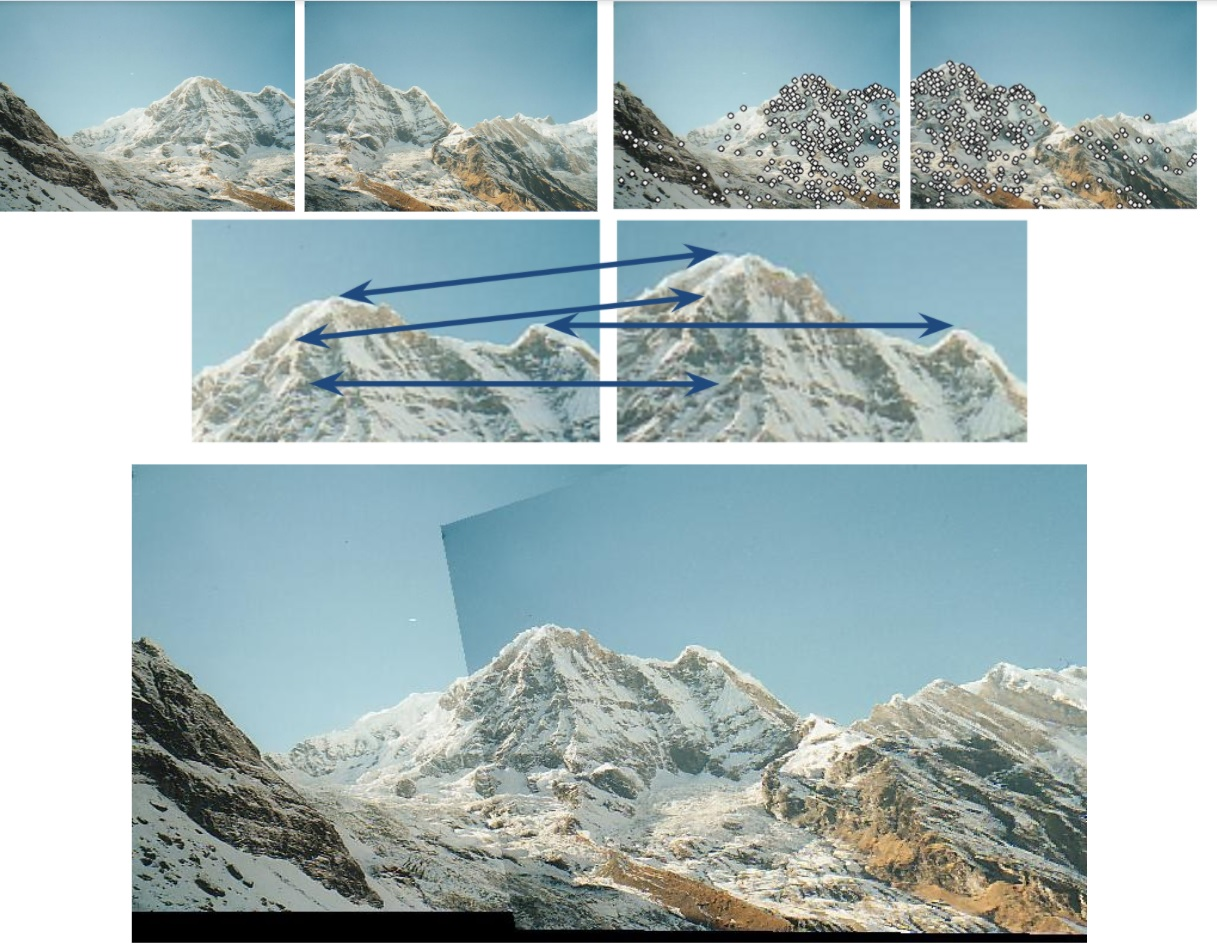

## Week 2: RANSAC & perspective transform
###The process of creating a panoramic image consists of the following steps:
1.  Detect keypoints and descriptors (done last week)
2.  Detect a set of matching points that is present in both images - overlapping area (done last week) **
3.  **Apply the RANSAC method to improve the matching process detection (to do)**
4.  **Apply perspective transformation on one image using the other image as a reference frame (to do)**
5.  **Stitch images together (to do)**

In [26]:
import os
import sys

import cv2 
import matplotlib.pyplot as plt
import numpy as np

In [27]:
#TODO: compute sorted image paths at specified location (paths.list_images)
# Function to compute sorted image paths at specified location
def sorted_image_paths(directory):
    # Get list of files in directory
    file_list = os.listdir(directory)
    # Filter out only image files
    image_files = [file for file in file_list if file.endswith(('.jpg', '.jpeg', '.png'))]
    # Sort the image files
    sorted_paths = sorted([os.path.join(directory, file) for file in image_files])
    return sorted_paths

# Specify the directory containing the images
path = "panorama/"

# Compute sorted image paths
imagePaths = sorted_image_paths(path)
print(imagePaths)

# Read all images
images = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    images.append(image)

['panorama/yosemite1.jpg', 'panorama/yosemite2.jpg', 'panorama/yosemite3.jpg', 'panorama/yosemite4.jpg']


In [28]:
#TODO: compute keypoints (keypoints1, keypoints2) & descriptors using SURF  
# match the descriptors using a FLANN based matcher
# filter matches using Lowe's ratio test (good_matches)
# draw matches (img_matches)

def compute_KP_matches(img1, img2): 
    # Initialize SURF detector
    surf = cv2.SIFT().create()

    # Detect keypoints and compute descriptors for both images
    keypoints1, descriptors1 = surf.detectAndCompute(img1, None)
    keypoints2, descriptors2 = surf.detectAndCompute(img2, None)

    # Initialize FLANN matcher
    flann = cv2.FlannBasedMatcher().create()

    # Match descriptors using FLANN matcher
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Apply Lowe's ratio test to filter matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Draw matches
    img_matches = cv2.drawMatches(
        img1=img1, 
        keypoints1=keypoints1, 
        img2=img2, 
        keypoints2=keypoints2, 
        matches1to2=good_matches, 
        outImg=None, 
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return keypoints1, keypoints2, good_matches, img_matches

###What is a homography matrix?
In the field of computer vision, any two images of the same scene are related by a homography. It is a transformation that maps the points in one image to the corresponding points in the other image. The two images can lay on the same surface in space or they are taken by rotating the camera along its optical axis. The essence of the homography is the simple 3x3 matrix called the homography matrix.


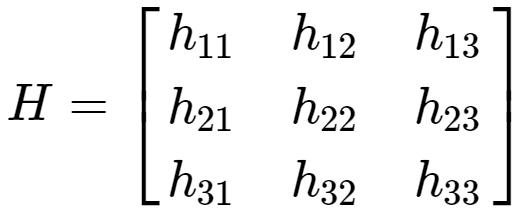

We can apply this matrix to any point in the image. For example, if we take a point A(x1,y1) in the first image we can use a homography matrix to map this point A to the corresponding point B(x2,y2) in the second image.

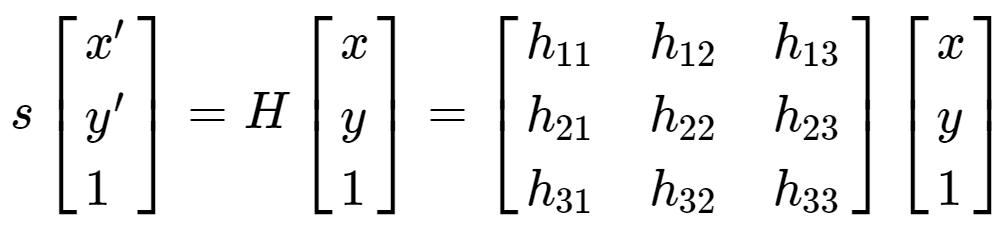

Now, using this technique we can easily stitch our images together. It is important to note that when we match feature points between two images, we only accept those matches that fall on the corresponding epipolar lines. We need these good matches to estimate the homography matrix. We detected a large number of keypoints and we need to reject some of them to retain the best ones.

As we already explained this 3x3 matrix will be used to transform the second image to have the same perspective as the first one which will be kept as the reference frame. Then, we will extract information about the transformation of the second image and use that information to align the second image with the first one.

To find this transformation matrix, we need to extract coordinates of a minimum of 4 points in the first image and corresponding 4 points in the second image. These points are related by homography so we can apply a transformation to change the perspective of the second image using the first image as a reference frame. In the following image, you can see an example of this transformation.


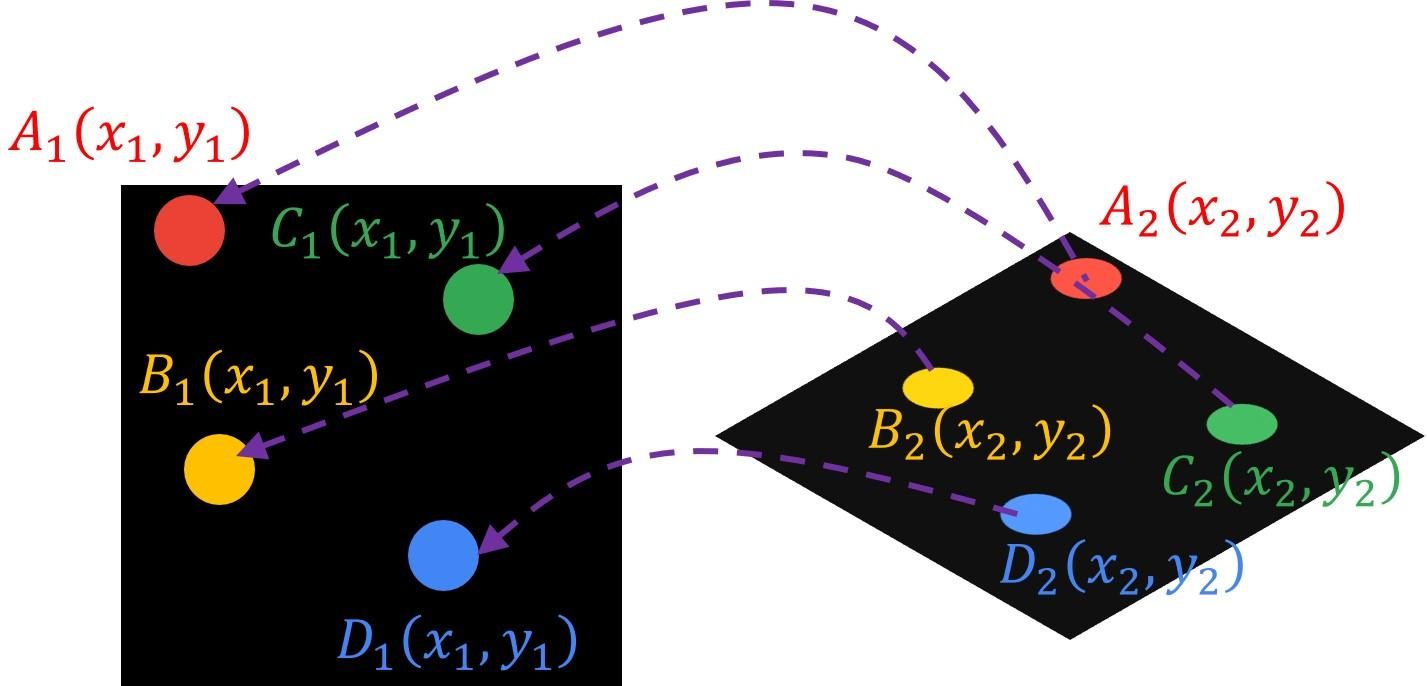

###RANdom SAmple Consensus (RANSAC)
 
* An example of a “voting”-based fitting scheme
* Each hypothesis gets voted on by each data point, best hypothesis wins
* There are many other types of voting schemes
 > Hough transforms
 
**General version:** 
1. Randomly choose s samples
  
  > Typically s = minimum sample size that lets you fit a model
2. Fit a model (e.g., line) to those samples
3. Count the number of inliers that approximately fit the model
4. Repeat N times
5. Choose the model that has the largest set of inliers
 
**Idea:**
1. Given a hypothesized line
2. Count the number of points that “agree” with the line
  > “Agree” = within a small distance of the line 
  
  > I.e., the inliers to that line
3.For all possible lines, select the one with the largest number of inliers


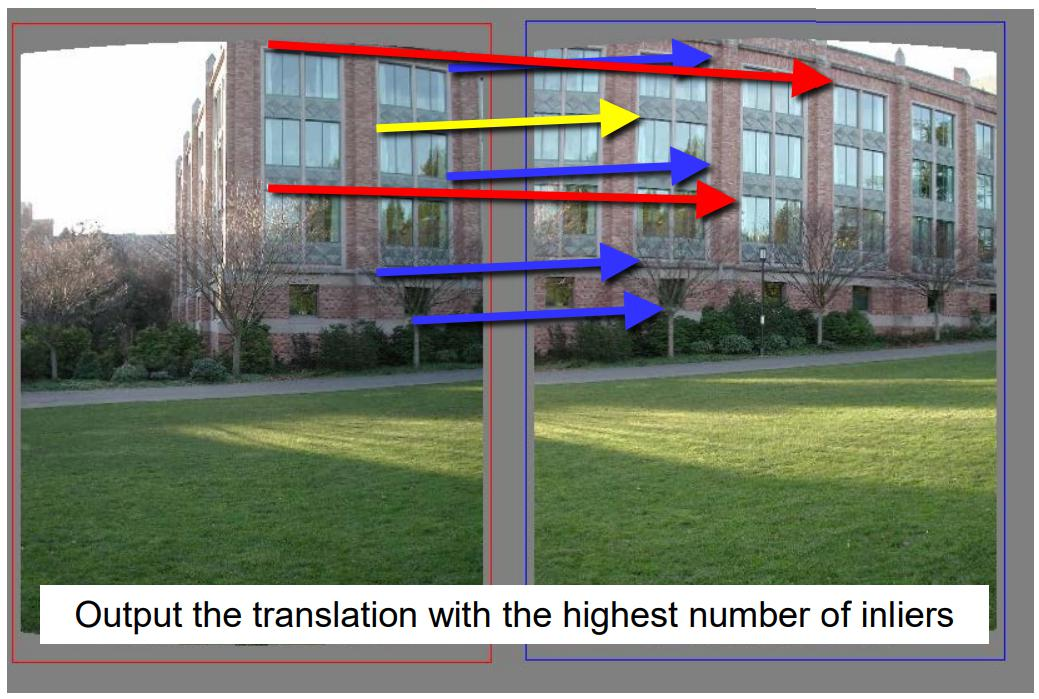

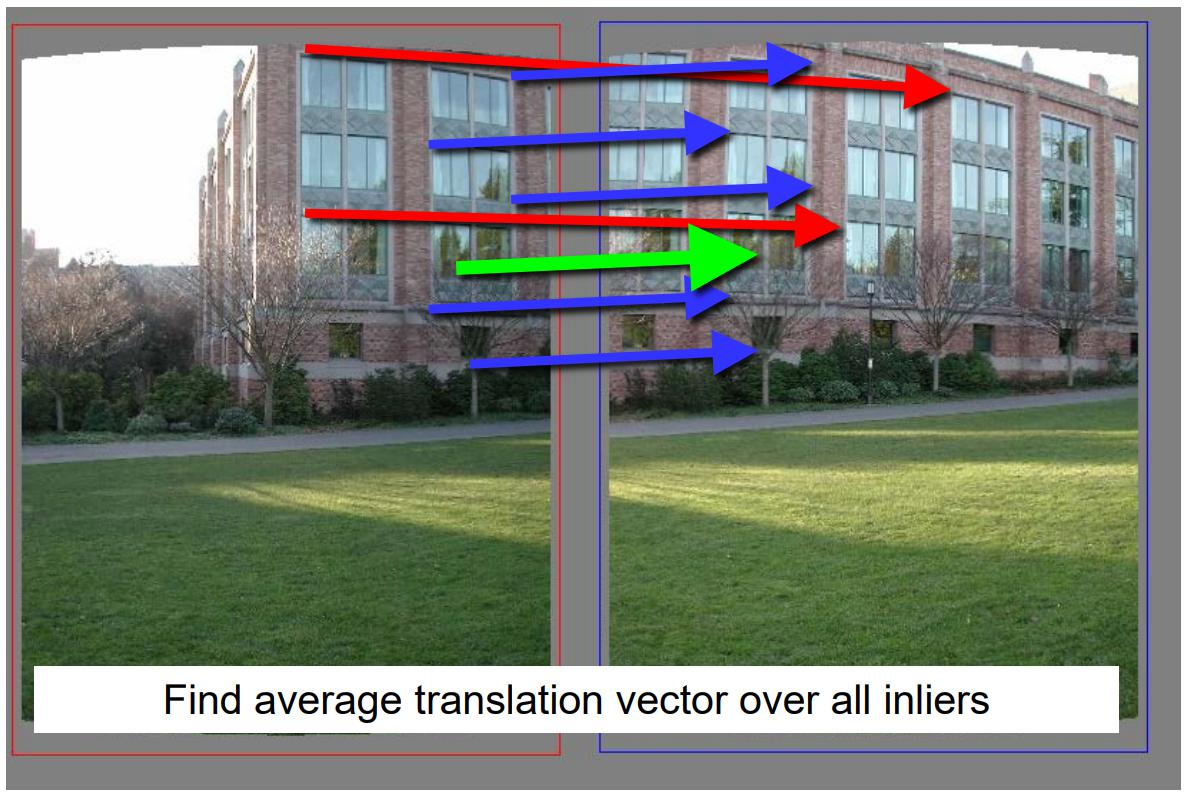

In [29]:
#TODO: compute Homography using RANSAC (cv2.findHomography)
# minimum matches after filtering > 10

def find_H(keypoints1, keypoints2, good_matches):
    if len(good_matches) > 10:
        # Extract the coordinates of the matched keypoints
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Compute homography matrix using RANSAC
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        return H

In [30]:
#TODO: wrap images (cv2.perspectiveTransform, cv2.warpPerspective)
# corners can be used to wrap perspective
def warp_images(img1, img2, H):  
    # Warp the first image using the homography
    result = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
    
    # Blending the warped image with the second image using alpha blending
    alpha = 0.1  # blending factor
    blended_image = cv2.addWeighted(result, alpha, img2, 1 - alpha, 0)

    return blended_image

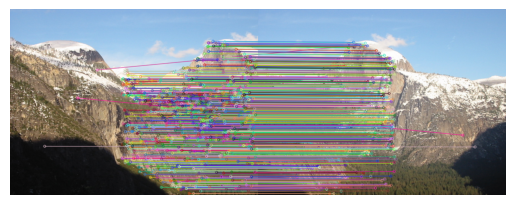

In [31]:
keypoints1, keypoints2, good_matches, img_matches = compute_KP_matches(images[0], images[1])
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis
plt.show()

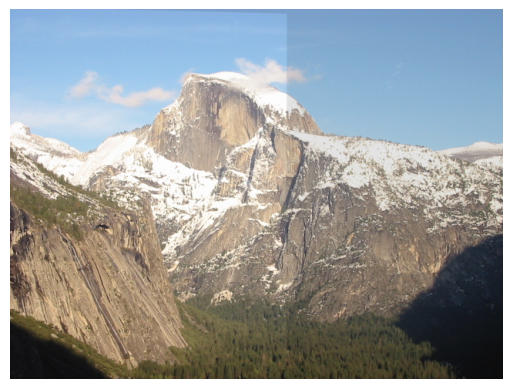

In [32]:
# Compute the homography matrix
H = find_H(keypoints1, keypoints2, good_matches)

# Warp the second image to align with the first image
img12 = warp_images(images[0], images[1], H)

# Display the resulting panorama
plt.imshow(cv2.cvtColor(img12, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis
plt.show()

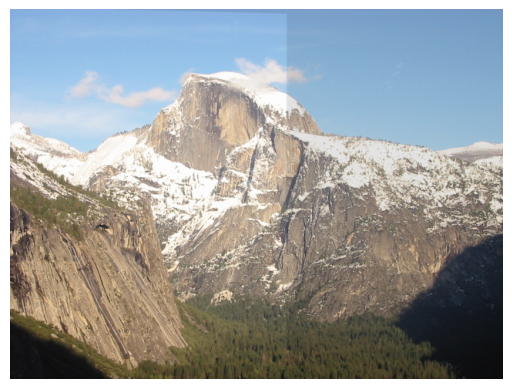

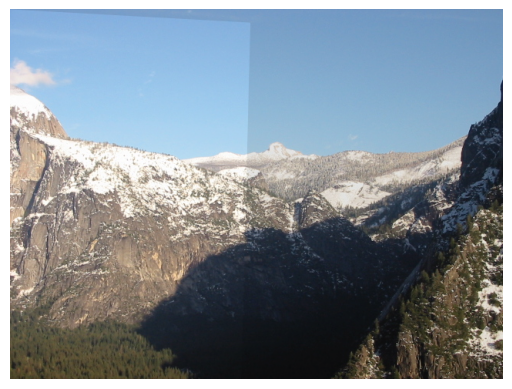

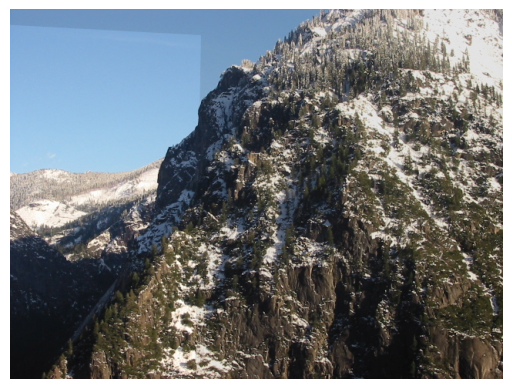

In [33]:
# Iterate through pairs of images
for i in range(len(images) - 1):
    # Compute keypoints and matches between current image and the next one
    keypoints1, keypoints2, good_matches, img_matches = compute_KP_matches(images[i], images[i+1])

    # Compute the homography matrix
    H = find_H(keypoints1, keypoints2, good_matches)

    # Warp the second image to align with the first image
    img12 = warp_images(images[i], images[i+1], H)

    # Display the resulting panorama
    plt.imshow(cv2.cvtColor(img12, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Turn off axis
    plt.show()

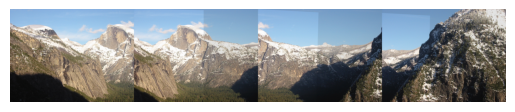

In [34]:
# Initialize stitched image with the first image
stitched_image = images[0]

# Iterate through pairs of images
for i in range(len(images) - 1):
    # Compute keypoints and matches between current image and the next one
    keypoints1, keypoints2, good_matches, img_matches = compute_KP_matches(stitched_image, images[i+1])

    # Compute the homography matrix
    H = find_H(keypoints1, keypoints2, good_matches)

    # Warp the next image to align with the stitched image
    warped_image = warp_images(stitched_image, images[i+1], H)

    # Create a canvas large enough to accommodate both stitched and warped images
    h1, w1 = stitched_image.shape[:2]
    h2, w2 = warped_image.shape[:2]
    max_height = max(h1, h2)
    total_width = w1 + w2
    canvas = np.zeros((max_height, total_width, 3), dtype=np.uint8)

    # Place the stitched image on the canvas
    canvas[:h1, :w1] = stitched_image

    # Place the warped image on the canvas
    canvas[:h2, w1:w1+w2] = warped_image

    # Update the stitched image with the combined result
    stitched_image = canvas

# Display the resulting panorama
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis
plt.show()


['campus/campus_000.jpg', 'campus/campus_001.jpg', 'campus/campus_002.jpg', 'campus/campus_003.jpg', 'campus/campus_004.jpg', 'campus/campus_005.jpg', 'campus/campus_006.jpg', 'campus/campus_007.jpg', 'campus/campus_008.jpg', 'campus/campus_009.jpg', 'campus/campus_010.jpg', 'campus/campus_011.jpg', 'campus/campus_012.jpg', 'campus/campus_013.jpg', 'campus/campus_014.jpg', 'campus/campus_015.jpg', 'campus/campus_016.jpg', 'campus/campus_017.jpg']


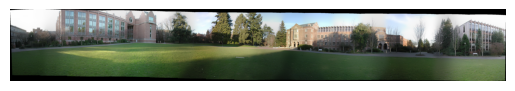

Stitching completed successfully.


In [38]:
# Specify the directory containing the images
path = "campus/"

# Compute sorted image paths
imagePaths = sorted_image_paths(path)
print(imagePaths)

# Read all images
images = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    images.append(image)

stitcher = cv2.Stitcher.create()
status, pano = stitcher.stitch(images)
 
# Check stitching status
if status == cv2.Stitcher_OK:
    # Convert BGR image to RGB for matplotlib
    pano_rgb = cv2.cvtColor(pano, cv2.COLOR_BGR2RGB)
    
    # Display the resulting panorama
    plt.imshow(pano_rgb)
    plt.axis('off')
    plt.show()
    
    # You can also save the resulting panorama using cv2.imwrite() if needed
    # cv2.imwrite('panorama_result.jpg', pano)
    print("Stitching completed successfully.")
else:
    print("Can't stitch images, error code = %d" % status)

In [36]:
# https://github.com/KEDIARAHUL135/PanoramaStitchingP2/blob/master/main.py
#TODO: Alternative solution for a 360 panorama
import os
import cv2
import numpy as np

def ReadImage(ImageFolderPath):
    # Compute sorted image paths
    imagePaths = sorted_image_paths(ImageFolderPath)
    print(imagePaths)
    
    # Read all images
    images = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        images.append(image)
        
    return images

    
def FindMatches(BaseImage, SecImage):
    # Using SIFT to find the keypoints and decriptors in the images
    Sift = cv2.SIFT.create()
    BaseImage_kp, BaseImage_des = Sift.detectAndCompute(cv2.cvtColor(BaseImage, cv2.COLOR_BGR2GRAY), None)
    SecImage_kp, SecImage_des = Sift.detectAndCompute(cv2.cvtColor(SecImage, cv2.COLOR_BGR2GRAY), None)

    # Using Brute Force matcher to find matches.
    BF_Matcher = cv2.BFMatcher()
    InitialMatches = BF_Matcher.knnMatch(BaseImage_des, SecImage_des, k=2)

    # Applytng ratio test and filtering out the good matches.
    GoodMatches = []
    for m, n in InitialMatches:
        if m.distance < 0.75 * n.distance:
            GoodMatches.append([m])

    return GoodMatches, BaseImage_kp, SecImage_kp



def FindHomography(Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code.
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    # Storing coordinates of points corresponding to the matches found in both the images
    BaseImage_pts = []
    SecImage_pts = []
    for Match in Matches:
        BaseImage_pts.append(BaseImage_kp[Match[0].queryIdx].pt)
        SecImage_pts.append(SecImage_kp[Match[0].trainIdx].pt)

    # Changing the datatype to "float32" for finding homography
    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)

    # Finding the homography matrix(transformation matrix).
    (HomographyMatrix, Status) = cv2.findHomography(SecImage_pts, BaseImage_pts, cv2.RANSAC, 4.0)

    return HomographyMatrix, Status

    
def GetNewFrameSizeAndMatrix(HomographyMatrix, Sec_ImageShape, Base_ImageShape):
    # Reading the size of the image
    (Height, Width) = Sec_ImageShape
    
    # Taking the matrix of initial coordinates of the corners of the secondary image
    # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
    # Where (xt, yt) is the coordinate of the i th corner of the image. 
    InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                              [0, 0, Height - 1, Height - 1],
                              [1, 1, 1, 1]])
    
    # Finding the final coordinates of the corners of the image after transformation.
    # NOTE: Here, the coordinates of the corners of the frame may go out of the 
    # frame(negative values). We will correct this afterwards by updating the 
    # homography matrix accordingly.
    FinalMatrix = np.dot(HomographyMatrix, InitialMatrix)

    [x, y, c] = FinalMatrix
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the stitched image frame and the "Correction" factor
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    New_Width = max_x
    New_Height = max_y
    Correction = [0, 0]
    if min_x < 0:
        New_Width -= min_x
        Correction[0] = abs(min_x)
    if min_y < 0:
        New_Height -= min_y
        Correction[1] = abs(min_y)
    
    # Again correcting New_Width and New_Height
    # Helpful when secondary image is overlaped on the left hand side of the Base image.
    if New_Width < Base_ImageShape[1] + Correction[0]:
        New_Width = Base_ImageShape[1] + Correction[0]
    if New_Height < Base_ImageShape[0] + Correction[1]:
        New_Height = Base_ImageShape[0] + Correction[1]

    # Finding the coordinates of the corners of the image if they all were within the frame.
    x = np.add(x, Correction[0])
    y = np.add(y, Correction[1])
    OldInitialPoints = np.float32([[0, 0],
                                   [Width - 1, 0],
                                   [Width - 1, Height - 1],
                                   [0, Height - 1]])
    NewFinalPonts = np.float32(np.array([x, y]).transpose())

    # Updating the homography matrix. Done so that now the secondary image completely 
    # lies inside the frame
    HomographyMatrix = cv2.getPerspectiveTransform(OldInitialPoints, NewFinalPonts)
    
    return [New_Height, New_Width], Correction, HomographyMatrix



def StitchImages(BaseImage, SecImage):
    # Applying Cylindrical projection on SecImage
    SecImage_Cyl, mask_x, mask_y = ProjectOntoCylinder(SecImage)

    # Getting SecImage Mask
    SecImage_Mask = np.zeros(SecImage_Cyl.shape, dtype=np.uint8)
    SecImage_Mask[mask_y, mask_x, :] = 255

    # Finding matches between the 2 images and their keypoints
    Matches, BaseImage_kp, SecImage_kp = FindMatches(BaseImage, SecImage_Cyl)
    
    # Finding homography matrix.
    HomographyMatrix, Status = FindHomography(Matches, BaseImage_kp, SecImage_kp)
    
    # Finding size of new frame of stitched images and updating the homography matrix 
    NewFrameSize, Correction, HomographyMatrix = GetNewFrameSizeAndMatrix(HomographyMatrix, SecImage_Cyl.shape[:2], BaseImage.shape[:2])

    # Finally placing the images upon one another.
    SecImage_Transformed = cv2.warpPerspective(SecImage_Cyl, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    SecImage_Transformed_Mask = cv2.warpPerspective(SecImage_Mask, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    BaseImage_Transformed = np.zeros((NewFrameSize[0], NewFrameSize[1], 3), dtype=np.uint8)
    BaseImage_Transformed[Correction[1]:Correction[1]+BaseImage.shape[0], Correction[0]:Correction[0]+BaseImage.shape[1]] = BaseImage

    StitchedImage = cv2.bitwise_or(SecImage_Transformed, cv2.bitwise_and(BaseImage_Transformed, cv2.bitwise_not(SecImage_Transformed_Mask)))

    return StitchedImage


def Convert_xy(x, y):
    global center, f

    xt = ( f * np.tan( (x - center[0]) / f ) ) + center[0]
    yt = ( (y - center[1]) / np.cos( (x - center[0]) / f ) ) + center[1]
    
    return xt, yt


def ProjectOntoCylinder(InitialImage):
    global w, h, center, f
    h, w = InitialImage.shape[:2]
    center = [w // 2, h // 2]
    f = 1100       # 1100 field; 1000 Sun; 1500 Rainier; 1050 Helens
    
    # Creating a blank transformed image
    TransformedImage = np.zeros(InitialImage.shape, dtype=np.uint8)
    
    # Storing all coordinates of the transformed image in 2 arrays (x and y coordinates)
    AllCoordinates_of_ti =  np.array([np.array([i, j]) for i in range(w) for j in range(h)])
    ti_x = AllCoordinates_of_ti[:, 0]
    ti_y = AllCoordinates_of_ti[:, 1]
    
    # Finding corresponding coordinates of the transformed image in the initial image
    ii_x, ii_y = Convert_xy(ti_x, ti_y)

    # Rounding off the coordinate values to get exact pixel values (top-left corner)
    ii_tl_x = ii_x.astype(int)
    ii_tl_y = ii_y.astype(int)

    # Finding transformed image points whose corresponding 
    # initial image points lies inside the initial image
    GoodIndices = (ii_tl_x >= 0) * (ii_tl_x <= (w-2)) * \
                  (ii_tl_y >= 0) * (ii_tl_y <= (h-2))

    # Removing all the outside points from everywhere
    ti_x = ti_x[GoodIndices]
    ti_y = ti_y[GoodIndices]
    
    ii_x = ii_x[GoodIndices]
    ii_y = ii_y[GoodIndices]

    ii_tl_x = ii_tl_x[GoodIndices]
    ii_tl_y = ii_tl_y[GoodIndices]

    # Bilinear interpolation
    dx = ii_x - ii_tl_x
    dy = ii_y - ii_tl_y

    weight_tl = (1.0 - dx) * (1.0 - dy)
    weight_tr = (dx)       * (1.0 - dy)
    weight_bl = (1.0 - dx) * (dy)
    weight_br = (dx)       * (dy)
    
    TransformedImage[ti_y, ti_x, :] = ( weight_tl[:, None] * InitialImage[ii_tl_y,     ii_tl_x,     :] ) + \
                                      ( weight_tr[:, None] * InitialImage[ii_tl_y,     ii_tl_x + 1, :] ) + \
                                      ( weight_bl[:, None] * InitialImage[ii_tl_y + 1, ii_tl_x,     :] ) + \
                                      ( weight_br[:, None] * InitialImage[ii_tl_y + 1, ii_tl_x + 1, :] )


    # Getting x coorinate to remove black region from right and left in the transformed image
    min_x = min(ti_x)

    # Cropping out the black region from both sides (using symmetricity)
    TransformedImage = TransformedImage[:, min_x : -min_x, :]

    return TransformedImage, ti_x-min_x, ti_y    

['campus/campus_000.jpg', 'campus/campus_001.jpg', 'campus/campus_002.jpg', 'campus/campus_003.jpg', 'campus/campus_004.jpg', 'campus/campus_005.jpg', 'campus/campus_006.jpg', 'campus/campus_007.jpg', 'campus/campus_008.jpg', 'campus/campus_009.jpg', 'campus/campus_010.jpg', 'campus/campus_011.jpg', 'campus/campus_012.jpg', 'campus/campus_013.jpg', 'campus/campus_014.jpg', 'campus/campus_015.jpg', 'campus/campus_016.jpg', 'campus/campus_017.jpg']


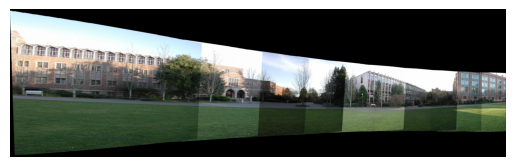

In [37]:
# Specify the directory containing the images
path = "campus/"

# Reading images.
Images = ReadImage(path)

BaseImage, _, _ = ProjectOntoCylinder(Images[0])
for i in range(0, 10):
    StitchedImage = StitchImages(BaseImage, Images[i])

    BaseImage = StitchedImage.copy()    

cv2.imwrite("Stitched_Panorama_campus.png", BaseImage)

plt.imshow(cv2.cvtColor(BaseImage, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis
plt.show()